In [23]:
!pip install tensorflow

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 ## Model Training

This model is relatively complex, and will require 30 minutes, or more, to fully train. 

**Skip ths section if you do not wish to spend time training the model. You can load a saved model in the next section.**

In [26]:
train_dir = os.path.join('data','train')
val_dir = os.path.join('data','test')
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size= 64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size= 64,
        color_mode="grayscale",
        class_mode='categorical')

emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))
# emotion_model.load_weights('emotion_model.h5')




emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)
emotion_model.save_weights('models/emotion_model.h5')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/50
448/448 [==============================] - 132s 293ms/step - loss: 1.7932 - accuracy: 0.2651 - val_loss: 1.6801 - val_accuracy: 0.3545
Epoch 2/50
448/448 [==============================] - 126s 282ms/step - loss: 1.6161 - accuracy: 0.3718 - val_loss: 1.5410 - val_accuracy: 0.4025
Epoch 3/50
448/448 [==============================] - 130s 289ms/step - loss: 1.5217 - accuracy: 0.4161 - val_loss: 1.4549 - val_accuracy: 0.4468
Epoch 4/50
448/448 [==============================] - 130s 289ms/step - loss: 1.4515 - accuracy: 0.4477 - val_loss: 1.3991 - val_accuracy: 0.4690
Epoch 5/50
448/448 [==============================] - 127s 284ms/step - loss: 1.3887 - accuracy: 0.4708 - val_loss: 1.3428 - val_accuracy: 0.4877
Epoch 6/50
448/448 [==============================] - 128s 285ms/step - loss: 1.3380 - accuracy: 0.4906 - val_loss: 1.3090 - val_accuracy: 0.5049
Epoch 7/50
448/448 [===================

### Training Results

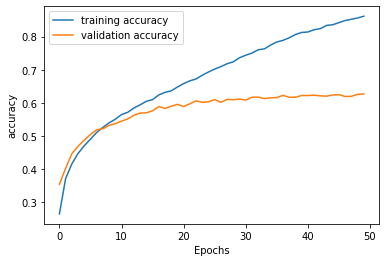

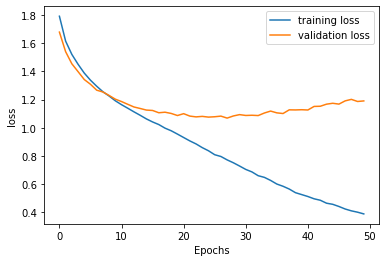

In [47]:
def plot_training(model_history, measure):
    plt.plot(model_history.history[measure])
    plt.plot(model_history.history['val_'+measure])
    plt.xlabel('Epochs')
    plt.ylabel(measure)
    plt.legend(['training '+ measure,'validation '+ measure])
    plt.show()
    
plot_training(emotion_model_info, 'accuracy')
plot_training(emotion_model_info, 'loss')

In [41]:
emotion_model.save('models/emotion_model_full.h5')

 ## Load Model for testing

This is a model that is able to be trained quickly on 1-2 epochs, and can be used to test the rest of the code

In [42]:
emotion_model_path = os.path.join('models','emotion_model_full.h5')
emotion_model = tf.keras.models.load_model(emotion_model_path)

## Webcam image capture

This section of the code activate the users webcam, isolates a face, and passes an image of the face into the model for predictions. 
- The model will print a number between 0 and 6 with its prediction for the emotion you are displaying.
**Pres the stop key to when you are done to disable your webcam and end predictions.**

In [43]:
cv2.ocl.setUseOpenCL(False)
emotion_dict = {0: "Angry",
                1: "Disgusted",
                2: "Fearful",
                3: "Happy",
                4: "Neutral",
                5: "Sad",
                6: "Surprised"}
bounding_box_path = os.path.join('xml','haarcascade_frontalface_default.xml')
# start the webcam feed
try:
    cap = cv2.VideoCapture(0)
    while True:
        # Find haar cascade to draw bounding box around face
        ret, frame = cap.read()
        if not ret:
            break
        bounding_box = cv2.CascadeClassifier(bounding_box_path)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in num_faces:
            cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
            roi_gray_frame = gray_frame[y:y + h, x:x + w]
            cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
            emotion_prediction = emotion_model.predict(cropped_img)
            maxindex = int(np.argmax(emotion_prediction))
            cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            print(maxindex)

        cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
except (KeyboardInterrupt, Exception) as e:
    cap.release()
    cv2.destroyAllWindows()
    print(repr(e))

cap.release()
cv2.destroyAllWindows()

4
4
3
3
3
3
3
3
3
0
0
0
4
2
4
3
3
3
3
3
3
3
3
3
2
2
4
6
6
6
2
2
6
6
4
6
6
3
6
6
KeyboardInterrupt()
